# Practico 7: Menel Angelo y Vietto Santiago

# Ejercicios:
1. El conjunto de datos clásico de caras Olivetti contiene 400 imágenes de caras en escala de grises de 64 × 64 píxeles. Cada imagen se aplana en un vector 1D de tamaño 4,096. Se fotografiaron 40 personas diferentes (10 veces cada una), y la tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen. Cargue el conjunto de datos utilizando la función sklearn.datasets.fetch_olivetti_faces(), luego divídalo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de prueba (note que el conjunto de datos ya está escalado entre 0 y 1). Dado que el conjunto de datos es bastante pequeño, probablemente desee utilizar un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto. A continuación, agrupe las imágenes utilizando K-Means y asegúrese de tener un buen número de clústeres (usando una de las técnicas discutidas en este capítulo). Visualice los clústeres: ¿ve caras similares en cada clúster?

In [ ]:
# Librerias

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [ ]:
dataset = fetch_olivetti_faces()

X = dataset.images
y = dataset.target

#Convierte el dataset.images a una matriz unidimensional
X_reshape = X.reshape(len(dataset.images), -1) 

X_train, X_test, y_train, y_test = train_test_split(X_reshape, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape)
print(X.shape)

(320, 4096)
(400, 64, 64)


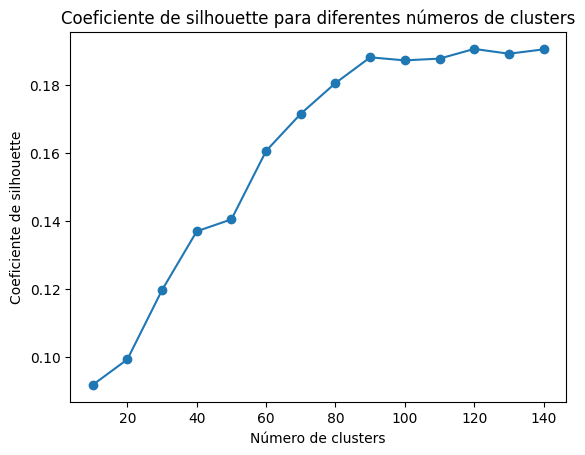

k= 10 -> 0.09171077
k= 20 -> 0.099230446
k= 30 -> 0.11962684
k= 40 -> 0.13690881
k= 50 -> 0.1404293
k= 60 -> 0.16056406
k= 70 -> 0.17150636
k= 80 -> 0.18052551
k= 90 -> 0.18809254
k= 100 -> 0.18720065
k= 110 -> 0.18772015
k= 120 -> 0.19056967
k= 130 -> 0.18915425
k= 140 -> 0.19044366


In [ ]:
# Lista para almacenar los coeficientes de silhouette
silhouette_scores = []

for k in range(10, 150, 10):
    kmeans = KMeans(n_clusters=k, n_init=1,random_state=42)
    cluster_labels = kmeans.fit_predict(X_train)
    
    # Calcula el coeficiente de silhouette para cada muestra
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Graficar los coeficientes de silhouette
plt.plot(range(10, 150, 10), silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de silhouette')
plt.title('Coeficiente de silhouette para diferentes números de clusters')
plt.show()

i=0
for k in range(10, 150, 10):
    print("k=",k,"->",silhouette_scores[i])
    i+=1

- Podemos observar que a partir de todos los coeficientes de silhouette con diferentes numeros de cluster, el que mejor con el que se agrupan los datos son 120 clusters.

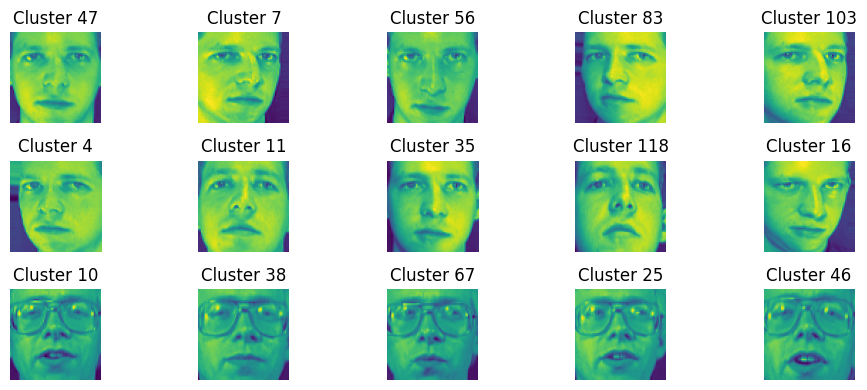

In [ ]:
#Diccionario para almacenar muestras
cluster_samples = {}

kmeans = KMeans(n_clusters=120,n_init = 5, random_state=42)
cluster_labels = kmeans.fit_predict(X_train)

#Recorrer las muestras y asignarlas a los cluster correspondientes
for i,label in enumerate(cluster_labels):
    if label not in cluster_samples:
        cluster_samples[label] = i


        
# Calcular el número de filas y columnas en la matriz de subfiguras
num_clusters = len(cluster_samples)
num_rows = (num_clusters + 4) // 5
num_cols = min(num_clusters, 5)


# Mostrar una imagen representativa de cada cluster
fig, axs = plt.subplots(3, 5, figsize=(10, 4))
for i, (label, sample_index) in enumerate(cluster_samples.items()):
    row = i // num_cols
    col = i % num_cols
    
    # Verificar si row y col superan el tamaño de axs
    if row >= axs.shape[0] or col >= axs.shape[1]:
        break
    
    image = X[sample_index].reshape(64, 64)  # Ajusta la forma de la imagen según tus necesidades
    axs[row, col].imshow(image)
    axs[row, col].set_title(f'Cluster {label}')
    axs[row, col].axis('off')

# Eliminar subfiguras vacías si es necesario
if num_clusters < num_rows * num_cols:
    for i in range(num_clusters, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axs[row, col])    
    
    
plt.tight_layout()
plt.show()

2. Continuando con el conjunto de datos de caras Olivetti, entrene un clasificador para predecir qué persona está representada en cada imagen y evalúelo en el conjunto de validación. A continuación, utilice K-Means como herramienta de reducción de dimensionalidad y entrene un clasificador en el conjunto reducido. Busque el número de clústeres que permita al clasificador obtener el mejor rendimiento: ¿qué rendimiento puede alcanzar? ¿Qué sucede si agrega las características del conjunto reducido a las características originales (nuevamente, buscando el mejor número de clústeres)?


In [ ]:
# Crear y entrenar el clasificador
classifier = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=42)
classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de validación
y_pred = classifier.predict(X_test)

# Calcular la precisión del clasificador
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score en el conjunto de validación:", accuracy)

Accuracy score en el conjunto de validación: 0.975


In [ ]:
pipeline = Pipeline([
    ('kmeans',KMeans(n_clusters=120,n_init=10,random_state=42)),
    ('log_reg',LogisticRegression(multi_class="ovr",max_iter=5000,random_state=42)),
])
pipeline.fit(X_train,y_train)

pipeline.score(X_test,y_test)

0.9125

In [ ]:
# Definir los parámetros a probar en la búsqueda de cuadrícula
param_grid = {
    'kmeans__n_clusters': range(10, 200, 10)
}

grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

Fitting 3 folds for each of 19 candidates, totalling 57 fits
[CV] END ..............................kmeans__n_clusters=10; total time=   1.6s
[CV] END ..............................kmeans__n_clusters=10; total time=   1.7s
[CV] END ..............................kmeans__n_clusters=10; total time=   1.5s
[CV] END ..............................kmeans__n_clusters=20; total time=   1.8s
[CV] END ..............................kmeans__n_clusters=20; total time=   1.8s
[CV] END ..............................kmeans__n_clusters=20; total time=   1.6s
[CV] END ..............................kmeans__n_clusters=30; total time=   2.2s
[CV] END ..............................kmeans__n_clusters=30; total time=   2.2s
[CV] END ..............................kmeans__n_clusters=30; total time=   2.3s
[CV] END ..............................kmeans__n_clusters=40; total time=   2.7s
[CV] END ..............................kmeans__n_clusters=40; total time=   2.5s
[CV] END ..............................kmeans__n

{'kmeans__n_clusters': 110}

In [ ]:
# Obtener los mejores parámetros y el modelo final
best_params = grid_clf.best_params_
best_model = grid_clf.best_estimator_

# Calcular el accuracy score en el conjunto de validación
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score en el conjunto de validación:", accuracy)

Accuracy score en el conjunto de validación: 0.9125


- Creemos que la diferencia entre accuracy score del LogisticRegression en comparación al pipeline con los mejores hiperparametros es muy diferente debido a que el rendimiento del Kmeans depende de la inicialización de los clusters.

3. Entrene un modelo Gaussian Mixture en el conjunto de datos de caras Olivetti. Para acelerar el algoritmo, probablemente deberá reducir la dimensionalidad del conjunto de datos (por ejemplo, usando PCA, conservando el 99% de la varianza). Utilice el modelo para generar algunas caras nuevas (utilizando el método sample()), y visualícelas (si usó PCA, deberá utilizar su método inverse_transform()). Intente modificar algunas imágenes (por ejemplo, rotar, voltear, oscurecer) y vea si el modelo puede detectar las anomalías (es decir, compare la salida del método score_samples() para imágenes normales y anomalías).


----------------------------------------------------------------------------
New Faces


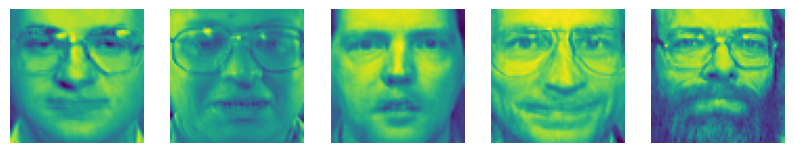

----------------------------------------------------------------------------
Modified Faces


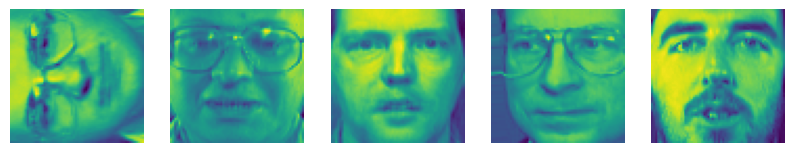

----------------------------------------------------------------------------
Normal Score      |      Anomaly Score
1293.1714113596065 | -29231248.394114546
1293.3731799736408 | -24873220.685513455
1300.699107195844 | -16740128.303994577
1315.7986834474946 | 1315.7984744886885


In [ ]:
# Reducción de dimensionalidad utilizando PCA
pca = PCA(n_components=0.99)  # Conservar el 99% de la varianza
faces_pca = pca.fit_transform(X_train)

# Entrenar el modelo Gaussian Mixture
gmm = GaussianMixture(n_components=120)
gmm.fit(faces_pca)

# Generar caras nuevas utilizando el método sample()
num_samples = 5
new_faces_pca = gmm.sample(num_samples)[0]
new_faces = pca.inverse_transform(new_faces_pca)

# Visualizar las caras generadas
print("----------------------------------------------------------------------------")
print("New Faces")
fig, axs = plt.subplots(1, num_samples, figsize=(10, 4))
for i in range(num_samples):
    face = new_faces[i].reshape(64, 64)
    axs[i].imshow(face)
    axs[i].axis('off')
plt.show()

print("----------------------------------------------------------------------------")
# Modificar algunas imágenes
modified_faces = np.copy(X_train)
face_mod = np.rot90(new_faces[0].reshape(64,64), k=1) # Rotar la primera imagen
modified_faces[0] = np.ravel(face_mod)

face_mod = np.fliplr(new_faces[1].reshape(64,64))  # Voltear horizontalmente la segunda imagen
modified_faces[1] = np.ravel(face_mod)

face_mod = new_faces[2].reshape(64,64) - 0.1 # Oscurecer la tercera imagen
modified_faces[2] = np.ravel(face_mod)

print("Modified Faces")
fig, axs = plt.subplots(1, num_samples, figsize=(10, 4))
for i in range(num_samples):
    face = modified_faces[i].reshape(64, 64)
    axs[i].imshow(face)
    axs[i].axis('off')
plt.show()
print("----------------------------------------------------------------------------")

# Calcular la puntuación de las imágenes normales y anomalías
normal_scores = gmm.score_samples(faces_pca)
anomaly_scores = gmm.score_samples(pca.transform(modified_faces))

print("Normal Score      |      Anomaly Score")
for i in range(0,4,1):    
    print(normal_scores[i],"|", anomaly_scores[i])


- En la Tabla de Normal Score en comparación de los Anomaly Score se ve que los primeros 3 en relacion a las nuevas caras con las caras modificadas realizada mas arriba, se muestra un gran porcentaje de anomalias.

4. Algunas técnicas de reducción de dimensionalidad también se pueden utilizar para la detección de anomalías. Por ejemplo, tome el conjunto de datos de caras Olivetti y redúzcalo con PCA, conservando el 99% de la varianza. Luego, calcule el error de reconstrucción para cada imagen. A continuación, tome algunas de las imágenes modificadas que construyó en el ejercicio anterior y observe su error de reconstrucción: observe cuánto mayor es el error de reconstrucción. Si traza una imagen reconstruida, verá por qué: intenta reconstruir una cara normal.


In [ ]:
pca = PCA(n_components=0.99)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_reconstructed = pca.inverse_transform(X_train_pca)
X_test_reconstructed = pca.inverse_transform(X_test_pca)

reconstruction_errors_train = np.mean((X_train - X_train_reconstructed)**2)
reconstruction_errors_test = np.mean((X_test - X_test_reconstructed)**2)

print("Error rec train:", reconstruction_errors_train)
print("Error rec test:", reconstruction_errors_test)

Error rec train: 0.00018999891
Error rec test: 0.0017894506


- La diferencia entre los errores de reconstrucción son muy diferentes debido a la cantidad de imagenes que tiene el training set y el test set.
- Los valores de reconstrucción los elevo al cuadrado para diferentes ventajas como: Resaltar diferencias significativas, Penaliza los errores grandes, Simplifica el calculo.

In [ ]:
modified_image_1 = modified_faces[0]
mod_im_1_transf = pca.transform(modified_image_1.reshape(1, -1))
mod_im_1_rec = pca.inverse_transform(mod_im_1_transf)

error_rec_imagen1 = np.mean((modified_image_1 - mod_im_1_rec)**2)

print("Error de reconstrucción imagen mod 1:", error_rec_imagen1)

modified_image_2 = modified_faces[1]
mod_im_2_transf = pca.transform(modified_image_2.reshape(1, -1))
mod_im_2_rec = pca.inverse_transform(mod_im_2_transf)

error_rec_imagen2 = np.mean((modified_image_2 - mod_im_2_rec)**2)

print("Error de reconstrucción imagen mod 2:", error_rec_imagen2)

X_train_im = X_train[0]
X_train_transf = pca.transform(X_train_im.reshape(1,-1))
X_train_reconstructed = pca.inverse_transform(X_train_transf)

error_rec_Xtrain_1 = np.mean((X_train_im - X_train_reconstructed)**2)

print("Error de reconstruccion imagen train:", error_rec_Xtrain_1)

Error de reconstrucción imagen mod 1: 0.0042380732
Error de reconstrucción imagen mod 2: 0.003658365
Error de reconstruccion imagen train: 0.000115377334


- A diferencia del calculo de reconstrucción de todo el training y test set, si lo calculamos imagen por imagen, terminamos observando que no hay mucha diferencia entre una sola imagen del training set, mientras que las caras modificadas es mucho mayor a causa de las anomalias que se hicieron previamente.

### Preguntas teóricas

1) ¿Cómo definirías el agrupamiento (clustering)? ¿Puedes nombrar algunos algoritmos de clustering?

Respuesta: el agrupamiento es una tecnica no supervisada para organizar conjuntos de datos en grupos con caracteristicas similares. Algunos algoritmos pueden ser Kmenas, DBSCAN, Gaussian Mixture Models.

2) ¿Cuáles son algunas de las principales aplicaciones de los algoritmos de clustering?

Respuesta: algunas de las principales aplicaciones de los algoritmos de clustering son reconocimiento de patrones, compresión de datos, analisis de redes sociales y analisis de textos.

3)  Describe dos técnicas para seleccionar el número adecuado de clusters al utilizar K-Means.
    
Respuesta: las tecnicas son:

* Elbow Method: consiste en calcular la suma de las distancias al cuadrado de cada punto dentro de su respectivo cluster y luego trazar el gráfico de la suma de las distancias en función del número de clusters. Se busca punto donde las distancias se estabilizan, es decir, donde la curva se aplana más.
* Silhouette Coefficient: se calcula para cada punto y representa la similitud del punto con su cluster en comparación con otros clusters cercanos. Se elige el numero de clusters que maximice el coeficiente.

4) ¿Qué es la propagación de etiquetas (label propagation)? ¿Por qué la implementarías y cómo?
  
Respuesta: la propagacion de etiquetas es un algoritmo semi-supervisado para asignar etiquetas a instancias no etiquetadas. Se implementa cuando el conjunto de datos es limitado y se quiere etiquetar más datos a partir de los pocos etiquetados que existen. Para implementarlo se preparan los datos con algunas instancias etiquetadas, se construye la matriz de afinidad (captura similitud entre instancias cercanas), se propaga las etiquetas (se etiqueta segun la matriz), se evalua y ajustan parametros.

5) ¿Puedes nombrar dos algoritmos de clustering que puedan escalar a conjuntos de datos grandes? ¿Y dos que busquen regiones de alta densidad?

Respuesta:
* Clustering para conjuntos de grandes datos: Kmeans++ (inicializa centroides eficientemente), DBSCAN (agrupa segun la densidad de los puntos).
* Clustering para regiones de alta densidad: DBSCAN, OPTICS (extension de DBSCAN, ordena segun conectividad y densidad relativa de instancias).

6) ¿Puedes pensar en un caso de uso donde el aprendizaje activo sería útil? ¿Cómo lo implementarías?
    
Respuesta: el aprendizaje activo es útil en situaciones donde tenemos un conjunto de datos etiquetados limitado y queremos maximizar la precisión del modelo a través de una selección inteligente de las instancias a etiquetar. Un caso de ejemplo donde se utilizaria es en la clasificación de documentos por categorias. Para implmenetarlo primero procesamos los datos, luego entrenamos un clasificador inicial, despues realizamos el aprendizaje activo, por siguiente actualizamos el modelo y por ultimo repito los ultimos 2 pasos hasta terminar.

7) ¿Cuál es la diferencia entre la detección de anomalías y la detección de novedades?

Respuesta: aunque ambos se centran en identificar instancias atípicas la diferencia entre ellos es que la detección de anomalías se centra en identificar desviaciones negativas con respecto al patrón general de los datos existentes, mientras que la detección de novedades busca identificar instancias que son completamente nuevas o desconocidas en relación con los datos existentes. 

8. ¿Qué es un modelo de Gaussian Mixture? ¿Para qué tareas se puede usar?

Respuesta: un modelo de Gaussian Mixture se basa en la suposición de que los datos provienen de una combinación de varias distribuciones gaussianas.Se estima la estructura subyacente de los datos mediante la asignación de una probabilidad a cada punto de datos para pertenecer a cada componente gaussiano. Estas probabilidades pueden utilizarse para realizar tareas como la clasificación, la agrupación o la generación de nuevos datos.

9. ¿Puedes nombrar dos técnicas para encontrar el número adecuado de clusters al usar un modelo de Gaussian Mixture?

Respuesta: las tecnicas para encontrar el número adecuado de clusters al usar un modelo de Gaussian Mixture son:
* Criterio de Información de Akaike (AIC) y Criterio de Información Bayesiano (BIC).
* Elbow Method.